# The Unconstrained (Total Constrained) Model


In [1]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np

In [2]:
pd.options.display.max_columns = 30

## Setting up some spatial data


In [3]:
#Fetch a GeoJson of some district-level boundaries from the ONS Geoportal. First add the URL to an object
url = "http://geoportal.statistics.gov.uk/datasets/8edafbe3276d4b56aec60991cbddda50_2.geojson"
EW = gpd.read_file(url)

make sure the boundaries have downloaded OK...

<AxesSubplot:>

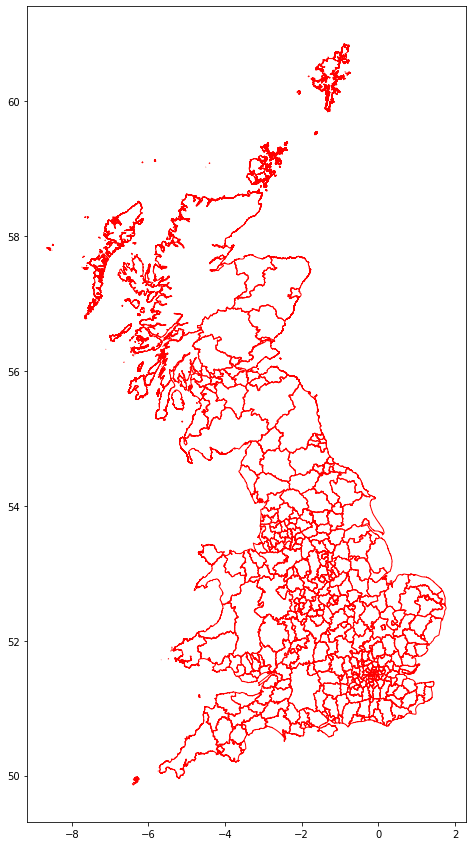

In [4]:
EW.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")

In [5]:
EW.head(10)

,objectid,lad15cd,lad15nm,lad15nmw,st_areashape,st_lengthshape,geometry
0,1,E06000001,Hartlepool,,9.844169e+07,65270.302085,"POLYGON ((-1.26846 54.72612, -1.26858 54.72614..."
1,2,E06000002,Middlesbrough,,5.455358e+07,41055.846979,"POLYGON ((-1.25112 54.59153, -1.25173 54.59144..."
2,3,E06000003,Redcar and Cleveland,,2.538909e+08,101208.779781,"POLYGON ((-1.13633 54.64504, -1.13654 54.64510..."
3,4,E06000004,Stockton-on-Tees,,2.097308e+08,108085.159612,"POLYGON ((-1.31729 54.64480, -1.31756 54.64499..."
4,5,E06000005,Darlington,,1.974757e+08,107206.323036,"POLYGON ((-1.63768 54.61714, -1.63800 54.61720..."
5,6,E06000006,Halton,,9.032151e+07,60716.864614,"POLYGON ((-2.73037 53.39989, -2.73067 53.39994..."
6,7,E06000007,Warrington,,1.823836e+08,84154.518583,"POLYGON ((-2.49407 53.48010, -2.49410 53.48012..."
7,8,E06000008,Blackburn with Darwen,,1.370221e+08,65284.958201,"POLYGON ((-2.46850 53.78164, -2.46884 53.78175..."
8,9,E06000009,Blackpool,,4.315077e+07,36304.948644,"POLYGON ((-3.02048 53.85938, -3.02057 53.85940..."
9,10,E06000010,"Kingston upon Hull, City of",,8.149751e+07,45997.483017,"POLYGON ((-0.31613 53.81327, -0.31885 53.81288..."


extract London which corresponds to "E09" from the "lad15cd" column

In [6]:
London = EW[EW.lad15cd.str.contains("E09")]

<AxesSubplot:>

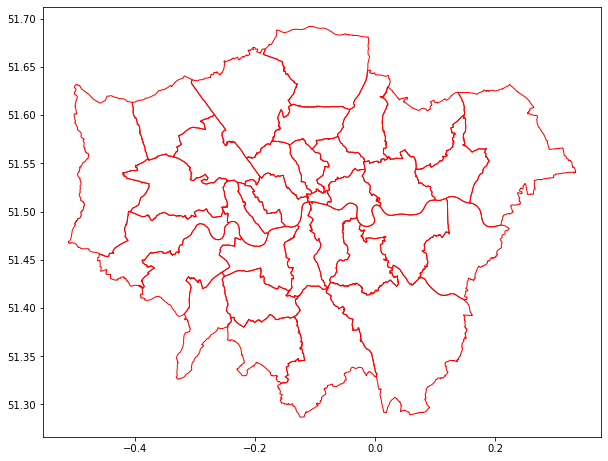

In [7]:
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")

In [8]:
#look under the bonnet
London.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
London.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33 entries, 293 to 325
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   objectid        33 non-null     int64   
 1   lad15cd         33 non-null     object  
 2   lad15nm         33 non-null     object  
 3   lad15nmw        33 non-null     object  
 4   st_areashape    33 non-null     float64 
 5   st_lengthshape  33 non-null     float64 
 6   geometry        33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(3)
memory usage: 2.1+ KB


## Calculting a distance matrix



/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


<AxesSubplot:>

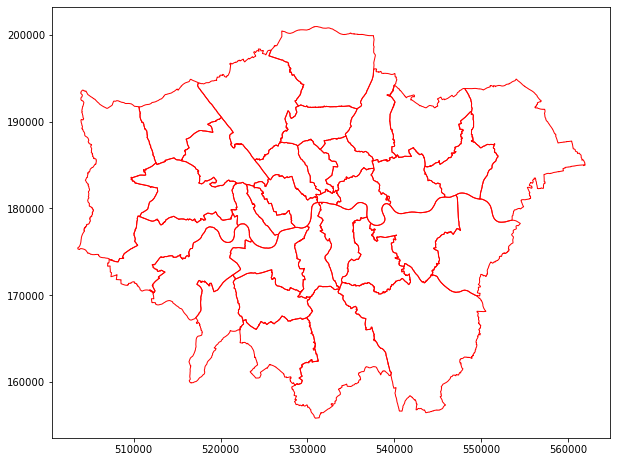

In [10]:
#transform london to BNG
London.to_crs("EPSG:27700", inplace = True)
#We can check that this has occured by plotting the results
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "r")

In [11]:
#order it by borough code - *This step will be important later on*
London.sort_values(by=["lad15cd"], inplace = True)

#extract the centroids
London["Centroids"] = London.geometry.centroid

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [12]:
London.set_index('lad15cd', inplace=True, drop=True)


In [13]:

#calculate distances from all borough centroids to all borough centroids
distances = London.rename_axis('Orig').Centroids.apply(lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
London.reset_index(inplace=True)

In [14]:
#Given that we have converted to the BNG already, this means that we could simply compute the Euclidean distance
#which can be done with this code

#drop any uncessary columns
LDN_cent = London.drop(columns = ["objectid", "lad15nm", "lad15nmw", "st_areashape", "st_lengthshape", "geometry"])

#extract the x and y coordinates
LDN_cent["x"] = LDN_cent["Centroids"].map(lambda p: p.x)
LDN_cent["y"] = LDN_cent["Centroids"].map(lambda p: p.y) 

#now drop the centroids
LDN_cent.drop(columns =[ "Centroids"], inplace = True)

#extract the distances for each possible pair
distances = []
for index1, row1 in LDN_cent.iterrows():
   for index2, row2 in LDN_cent.iterrows():
       #append the orig code, destination code and distance
       distances.append([row1["lad15cd"], row2["lad15cd"], 
                         ((float(row1["x"])-float(row2["x"]))**2 +(float(row1["y"])-float(row2["y"]))**2)**0.5])
        
#convert the resulting list into a dataframe        
distances = pd.DataFrame.from_records(distances, columns = ["Orig", "Dest", "Dist"])

#sort by origin code and then destination code
distances.sort_values(by=["Orig", "Dest"], inplace = True)

#check the results
distances

,Orig,Dest,Dist
0,E09000001,E09000001,0.000000
1,E09000001,E09000002,15995.228542
2,E09000001,E09000003,13935.670950
3,E09000001,E09000004,17359.908682
4,E09000001,E09000005,13119.797208
...,...,...,...
1084,E09000033,E09000029,16878.478719
1085,E09000033,E09000030,8735.485944
1086,E09000033,E09000031,13617.154003
1087,E09000033,E09000032,7067.552556


In [15]:
distances[distances['Dist']==0]

,Orig,Dest,Dist
0,E09000001,E09000001,0.0
34,E09000002,E09000002,0.0
68,E09000003,E09000003,0.0
102,E09000004,E09000004,0.0
136,E09000005,E09000005,0.0
170,E09000006,E09000006,0.0
204,E09000007,E09000007,0.0
238,E09000008,E09000008,0.0
272,E09000009,E09000009,0.0
306,E09000010,E09000010,0.0


## Flow data


In [16]:
#read ltds data
ltdsdata = pd.read_csv("LTDS_Data_2014_2020_copy.csv")
ltdsdata_1920 = ltdsdata[ltdsdata['Year'] == '2019/20']
ltdsdata_1920

,Unique trip ID,Trip weight,Year,Mode,Journey purpose,Distance (km),Gender,Age,Car access,Working status,Household structure,Disability,Trip start time period,Origin borough,Origin postcode sector,Destination borough,Destination postcode sector,Ethnicity,Household income
0,190010210101,217.798842,2019/20,01 Walk (roller blades/ scooters),04 Shopping and personal business,1.070,Female,32,00 No car,Not working,Single pensioner,Not disabled,AM peak (0700-0959),15 Barking & Dagenham,RM9 4,15 Barking & Dagenham,IG11 9,"02 Mixed, Other and Arab","03 ?10,000 - ?14,999"
1,190010210102,217.798842,2019/20,01 Walk (roller blades/ scooters),04 Shopping and personal business,1.070,Female,32,00 No car,Not working,Single pensioner,Not disabled,Interpeak (1000-1559),15 Barking & Dagenham,IG11 9,15 Barking & Dagenham,RM9 4,"02 Mixed, Other and Arab","03 ?10,000 - ?14,999"
2,190010510301,276.187543,2019/20,17 Underground,01 Usual workplace,15.193,Male,35,02 Two or more car,Full-time worker,Couple without children,Not disabled,AM peak (0700-0959),15 Barking & Dagenham,RM9 4,06 Islington,N1 8,03 Asian,"09 ?75,000 - ?99,999"
3,190010510302,276.187543,2019/20,17 Underground,01 Usual workplace,15.193,Male,35,02 Two or more car,Full-time worker,Couple without children,Not disabled,Evening (1900-2159),06 Islington,N1 8,15 Barking & Dagenham,RM9 4,03 Asian,"09 ?75,000 - ?99,999"
4,190010710101,694.504624,2019/20,17 Underground,03 Education,15.914,Male,55,01 One car,Part-time worker,Lone parent,Not disabled,AM peak (0700-0959),15 Barking & Dagenham,RM9 4,11 Southwark,SE1 0,03 Asian,"02 ?5,000 - ?9,999"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39122,195332710102,345.624484,2019/20,13 Bus (public),01 Usual workplace,4.875,Female,56,00 No car,Full-time worker,Single pensioner,Not disabled,PM peak (1600-1859),14 Westminster,W10 4,14 Westminster,W1W 7,03 Asian,"07 ?35,000 - ?49,999"
39123,195332710201,168.887148,2019/20,01 Walk (roller blades/ scooters),05 Leisure,0.701,Female,27,00 No car,Not working,Single pensioner,Not disabled,Interpeak (1000-1559),14 Westminster,W1W 7,14 Westminster,W1F 7,03 Asian,"07 ?35,000 - ?49,999"
39124,195332710202,168.887148,2019/20,01 Walk (roller blades/ scooters),05 Leisure,0.701,Female,27,00 No car,Not working,Single pensioner,Not disabled,Interpeak (1000-1559),14 Westminster,W1F 7,14 Westminster,W1W 7,03 Asian,"07 ?35,000 - ?49,999"
39125,195332710301,226.175449,2019/20,02 Pedal Cycle,05 Leisure,1.389,Male,22,00 No car,Not working,Single pensioner,Not disabled,Interpeak (1000-1559),14 Westminster,W1W 7,14 Westminster,W1H 7,03 Asian,"07 ?35,000 - ?49,999"


In [17]:
ltdsdata_1920['Mode']

0        01 Walk (roller blades/ scooters)
1        01 Walk (roller blades/ scooters)
2                           17 Underground
3                           17 Underground
4                           17 Underground
                       ...                
39122                      13 Bus (public)
39123    01 Walk (roller blades/ scooters)
39124    01 Walk (roller blades/ scooters)
39125                       02 Pedal Cycle
39126                       02 Pedal Cycle
Name: Mode, Length: 39127, dtype: object

In [18]:
cdata = ltdsdata_1920.groupby(['Origin borough', 'Destination borough'])['Mode'].agg('count')

In [19]:
cdata

Origin borough  Destination borough    
01 Camden       01 Camden                  731
                02 City of London           28
                03 Hackney                  29
                04 Hammersmith & Fulham     13
                05 Haringey                 45
                                          ... 
98 Missing      18 Brent                     1
                19 Bromley                   2
                24 Harrow                    1
                26 Hillingdon                1
                32 Sutton                    1
Name: Mode, Length: 1086, dtype: int64

In [20]:
cdata = pd.pivot_table(ltdsdata_1920, index=['Origin borough', 'Destination borough'], columns=['Mode'], aggfunc='count').reset_index()
cdata.columns = cdata.columns.droplevel(0)
cdata

Mode,,,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,...,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,16 Coach,17 Underground,18 DLR train,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail
0,01 Camden,01 Camden,574.0,3.0,35.0,25.0,NaN,NaN,NaN,NaN,1.0,NaN,55.0,NaN,NaN,...,1.0,NaN,55.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,5.0,3.0,1.0,9.0,NaN
1,01 Camden,02 City of London,7.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,NaN
2,01 Camden,03 Hackney,3.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,...,NaN,NaN,12.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
3,01 Camden,04 Hammersmith & Fulham,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,01 Camden,05 Haringey,5.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,...,NaN,NaN,9.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,98 Missing,18 Brent,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082,98 Missing,19 Bromley,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1083,98 Missing,24 Harrow,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1084,98 Missing,26 Hillingdon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
cdata = cdata.iloc[:,:25]

In [22]:
cdata

Mode,,,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,16 Coach,17 Underground,18 DLR train,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail
0,01 Camden,01 Camden,574.0,3.0,35.0,25.0,NaN,NaN,NaN,NaN,1.0,NaN,55.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,5.0,3.0,1.0,9.0,NaN
1,01 Camden,02 City of London,7.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,NaN
2,01 Camden,03 Hackney,3.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
3,01 Camden,04 Hammersmith & Fulham,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,01 Camden,05 Haringey,5.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,98 Missing,18 Brent,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082,98 Missing,19 Bromley,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1083,98 Missing,24 Harrow,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1084,98 Missing,26 Hillingdon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
cdata['total'] = cdata.iloc[:,2:].apply(lambda x: x.sum(), axis=1)
cdata

Mode,,,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,16 Coach,17 Underground,18 DLR train,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total
0,01 Camden,01 Camden,574.0,3.0,35.0,25.0,NaN,NaN,NaN,NaN,1.0,NaN,55.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,5.0,3.0,1.0,9.0,NaN,731.0
1,01 Camden,02 City of London,7.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,NaN,28.0
2,01 Camden,03 Hackney,3.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,29.0
3,01 Camden,04 Hammersmith & Fulham,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,13.0
4,01 Camden,05 Haringey,5.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,98 Missing,18 Brent,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1082,98 Missing,19 Bromley,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1083,98 Missing,24 Harrow,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1084,98 Missing,26 Hillingdon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [24]:
cdata.columns = ['Orig','Dest','01 Walk (roller blades/ scooters)','02 Pedal Cycle','03 Car Driver','04 Car Passenger','05 Motorcycle Rider','06 Motorcycle Passenger','09 Van small Driver','10 Van small Passenger','11 Van/ lorry (other) Driver','12 Van/ lorry (other) Passenger','13 Bus (public)','14 Bus (school/ work)','15 Dial a ride','16 Coach','17 Underground','18 DLR train','19 National rail train','20 Tramlink','21 Taxi (London black cab)','22 Taxi (other/ minicab)','23 Plane/ Boat/ Other','24 London Overground','25 TfL Rail','total']

In [25]:
cdata

,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,16 Coach,17 Underground,18 DLR train,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total
0,01 Camden,01 Camden,574.0,3.0,35.0,25.0,NaN,NaN,NaN,NaN,1.0,NaN,55.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,5.0,3.0,1.0,9.0,NaN,731.0
1,01 Camden,02 City of London,7.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,NaN,28.0
2,01 Camden,03 Hackney,3.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,29.0
3,01 Camden,04 Hammersmith & Fulham,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,13.0
4,01 Camden,05 Haringey,5.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,98 Missing,18 Brent,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1082,98 Missing,19 Bromley,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1083,98 Missing,24 Harrow,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1084,98 Missing,26 Hillingdon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [26]:
cdata.drop(cdata.loc[cdata['Orig']=='98 Missing'].index, axis=0,inplace = True)
cdata.drop(cdata.loc[cdata['Dest']=='98 Missing'].index, axis=0,inplace = True)
cdata

,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,16 Coach,17 Underground,18 DLR train,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total
0,01 Camden,01 Camden,574.0,3.0,35.0,25.0,NaN,NaN,NaN,NaN,1.0,NaN,55.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,5.0,3.0,1.0,9.0,NaN,731.0
1,01 Camden,02 City of London,7.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,NaN,28.0
2,01 Camden,03 Hackney,3.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,29.0
3,01 Camden,04 Hammersmith & Fulham,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,13.0
4,01 Camden,05 Haringey,5.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,52 Ouside London Area (M25),31 Richmond upon Thames,NaN,NaN,16.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0
1067,52 Ouside London Area (M25),32 Sutton,NaN,NaN,16.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0
1068,52 Ouside London Area (M25),33 Waltham Forest,1.0,NaN,2.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,11.0
1069,52 Ouside London Area (M25),"51 London Area, Outside Greater London",NaN,NaN,5.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0


In [27]:
cdata['Orig'] = cdata['Orig'].map(lambda x: str(x)[3:])

In [28]:
cdata['Dest'] = cdata['Dest'].map(lambda x: str(x)[3:])

In [29]:
cdata

,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,16 Coach,17 Underground,18 DLR train,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total
0,Camden,Camden,574.0,3.0,35.0,25.0,NaN,NaN,NaN,NaN,1.0,NaN,55.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,5.0,3.0,1.0,9.0,NaN,731.0
1,Camden,City of London,7.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,NaN,28.0
2,Camden,Hackney,3.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,29.0
3,Camden,Hammersmith & Fulham,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,13.0
4,Camden,Haringey,5.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,Ouside London Area (M25),Richmond upon Thames,NaN,NaN,16.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,27.0
1067,Ouside London Area (M25),Sutton,NaN,NaN,16.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0
1068,Ouside London Area (M25),Waltham Forest,1.0,NaN,2.0,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,NaN,11.0
1069,Ouside London Area (M25),"London Area, Outside Greater London",NaN,NaN,5.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0


In [30]:
#read in the London Commuting Data
#cdata = pd.read_csv("https://www.dropbox.com/s/7c1fi1txbvhdqby/LondonCommuting2001.csv?raw=1")
#read in a lookup table for translating between old borough codes and new borough codes
CodeLookup = pd.read_csv("https://www.dropbox.com/s/h8mpvnepdkwa1ac/CodeLookup.csv?raw=1")
#read in some population and income data
popincome = pd.read_csv("popincome.csv",thousands = ",")

In [31]:
cdata = cdata.merge(CodeLookup[['NewCode','Label']], left_on = "Orig", right_on = "Label")
cdata.rename(columns = {"NewCode": "OrigCodeNew"}, inplace = True)
cdata.drop(columns = ["Label"], inplace = True)
cdata

,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,16 Coach,17 Underground,18 DLR train,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total,OrigCodeNew
0,Camden,Camden,574.0,3.0,35.0,25.0,NaN,NaN,NaN,NaN,1.0,NaN,55.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,5.0,3.0,1.0,9.0,NaN,731.0,E09000007
1,Camden,City of London,7.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,2.0,NaN,1.0,2.0,NaN,NaN,NaN,28.0,E09000007
2,Camden,Hackney,3.0,4.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,29.0,E09000007
3,Camden,Hammersmith & Fulham,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,13.0,E09000007
4,Camden,Haringey,5.0,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,45.0,E09000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,Waltham Forest,Merton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,E09000031
844,Waltham Forest,Redbridge,21.0,3.0,26.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,1.0,NaN,3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,86.0,E09000031
845,Waltham Forest,Waltham Forest,193.0,10.0,106.0,64.0,NaN,NaN,3.0,2.0,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,448.0,E09000031
846,Waltham Forest,"London Area, Outside Greater London",NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,E09000031


In [32]:
cdata = cdata.merge(CodeLookup, left_on = "Dest", right_on = "Label")
cdata.rename(columns = {"NewCode": "DestCodeNew"}, inplace = True)
cdata.drop(columns = ["Label"], inplace = True)
cdata

,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,16 Coach,17 Underground,18 DLR train,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total,OrigCodeNew,OldCode,DestCodeNew
0,Camden,Camden,574.0,3.0,35.0,25.0,NaN,NaN,NaN,NaN,1.0,NaN,55.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,5.0,3.0,1.0,9.0,NaN,731.0,E09000007,00AG,E09000007
1,City of London,Camden,6.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,27.0,E09000001,00AG,E09000007
2,Hackney,Camden,2.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,29.0,E09000012,00AG,E09000007
3,Haringey,Camden,5.0,1.0,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,24.0,NaN,1.0,NaN,NaN,1.0,NaN,2.0,NaN,51.0,E09000014,00AG,E09000007
4,Islington,Camden,26.0,4.0,12.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,21.0,NaN,NaN,NaN,25.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,102.0,E09000019,00AG,E09000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,Greenwich,Waltham Forest,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,E09000011,00BH,E09000031
674,Havering,Waltham Forest,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,E09000016,00BH,E09000031
675,Merton,Waltham Forest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,E09000024,00BH,E09000031
676,Redbridge,Waltham Forest,17.0,3.0,28.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1.0,1.0,NaN,3.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,84.0,E09000026,00BH,E09000031


In [33]:
#add the population income (here I will use the median income as it is a more reliable indicator and not 
#affected by skewness as much as average income might be)
popincome.drop(columns = ["label", "avg_income"], inplace = True)

#merge on the origins
cdata = cdata.merge(popincome, left_on = "OrigCodeNew", right_on ="code")
cdata.drop(columns = ["code"], inplace = True)
cdata.rename(columns={"pop":"Oi1_origpop", "med_income": "Oi2_origsal"}, inplace = True)

#do the same with the destination
cdata = cdata.merge(popincome, left_on = "DestCodeNew", right_on ="code")
cdata.drop(columns = ["code"], inplace = True)
cdata.rename(columns={"pop":"Dj1_destpop", "med_income": "Dj2_destsal"}, inplace = True)

In [34]:
#the data needs to be ordered by borough code, if it's not then I will run into problems when we try to merge the 
#distance data back in later
cdata.sort_values(by=["OrigCodeNew", "DestCodeNew"], inplace = True)

#reset the resulting index (important for later) when merging back together
cdata.reset_index(inplace=True)
cdata.drop(columns = ["index"], inplace=True)

In [35]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Orig                               678 non-null    object 
 1   Dest                               678 non-null    object 
 2   01 Walk (roller blades/ scooters)  168 non-null    float64
 3   02 Pedal Cycle                     187 non-null    float64
 4   03 Car Driver                      398 non-null    float64
 5   04 Car Passenger                   284 non-null    float64
 6   05 Motorcycle Rider                59 non-null     float64
 7   06 Motorcycle Passenger            0 non-null      float64
 8   09 Van small Driver                85 non-null     float64
 9   10 Van small Passenger             14 non-null     float64
 10  11 Van/ lorry (other) Driver       31 non-null     float64
 11  12 Van/ lorry (other) Passenger    17 non-null     float64

In [36]:
distances.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 0 to 1088
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Orig    1089 non-null   object 
 1   Dest    1089 non-null   object 
 2   Dist    1089 non-null   float64
dtypes: float64(1), object(2)
memory usage: 34.0+ KB


In [37]:
cdata.rename(columns={"OrigCodeNew":"OrigCode", "DestCodeNew": "DestCode"}, inplace = True)

To finish I need to add in our distance data that we generated earlier and create a new column of total flows that excludes the flows that occur within boroughs (could keep the within-borough (intra-borough) flows in but they can cause problems so for now we will just exclude them).

In [38]:
#first create a new total column which excludes intra-borough flow totals (we will set them
#to a very small number for reasons you will see later)
cdata["TotalNoIntra"] = cdata.apply(lambda x: 0 if x['OrigCode'] == x['DestCode'] else x['total'], axis=1)

In [39]:
#set the number to a very small number
cdata["offset"]= cdata.apply(lambda x: 0.0000000001 if x['OrigCode'] == x['DestCode'] else 0, axis=1)

In [40]:
#add the distance column into the dataframe
#cdata = cdata.merge(distances['Dist'], left_index=True, right_index=True,on=['',''])

In [41]:
distances.rename(columns={"Orig":"OrigCode", "Dest": "DestCode"}, inplace = True)

Let's have a quick look at what the data now looks like

In [42]:
cdata=cdata.merge(distances,on=['OrigCode','DestCode'])

In [43]:
cdata

,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,...,22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total,OrigCode,OldCode,DestCode,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist
0,City of London,City of London,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,123.0,E09000001,00AA,E09000001,9547,54200,9547,54200,0.0,1.000000e-10,0.000000
1,City of London,Barnet,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.0,E09000001,00AC,E09000003,9547,54200,400064,30700,10.0,0.000000e+00,13935.670950
2,City of London,Bexley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,E09000001,00AD,E09000004,9547,54200,249284,28000,8.0,0.000000e+00,17359.908682
3,City of London,Brent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,E09000001,00AE,E09000005,9547,54200,332359,26200,5.0,0.000000e+00,13119.797208
4,City of London,Bromley,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.0,E09000001,00AF,E09000006,9547,54200,333978,33700,13.0,0.000000e+00,18740.822949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,Westminster,Sutton,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,20.0,E09000033,00BF,E09000029,265990,39900,207631,30200,20.0,0.000000e+00,16878.478719
674,Westminster,Tower Hamlets,NaN,1.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,1.0,NaN,NaN,NaN,35.0,E09000033,00BG,E09000030,265990,39900,331707,32700,35.0,0.000000e+00,8735.485944
675,Westminster,Waltham Forest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,35.0,E09000033,00BH,E09000031,265990,39900,278948,27700,35.0,0.000000e+00,13617.154003
676,Westminster,Wandsworth,6.0,7.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,...,5.0,NaN,NaN,NaN,67.0,E09000033,00BJ,E09000032,265990,39900,332065,38900,67.0,0.000000e+00,7067.552556


In [44]:
#look at the flows that originate from the city of London
cdata.head(33)

,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,...,22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total,OrigCode,OldCode,DestCode,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist
0,City of London,City of London,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,123.0,E09000001,00AA,E09000001,9547,54200,9547,54200,0.0,1.000000e-10,0.000000
1,City of London,Barnet,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.0,E09000001,00AC,E09000003,9547,54200,400064,30700,10.0,0.000000e+00,13935.670950
2,City of London,Bexley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,E09000001,00AD,E09000004,9547,54200,249284,28000,8.0,0.000000e+00,17359.908682
3,City of London,Brent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,E09000001,00AE,E09000005,9547,54200,332359,26200,5.0,0.000000e+00,13119.797208
4,City of London,Bromley,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.0,E09000001,00AF,E09000006,9547,54200,333978,33700,13.0,0.000000e+00,18740.822949
5,City of London,Camden,6.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,27.0,E09000001,00AG,E09000007,9547,54200,274695,38200,27.0,0.000000e+00,5742.818336
6,City of London,Croydon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11.0,E09000001,00AH,E09000008,9547,54200,388247,29400,11.0,0.000000e+00,17701.850875
7,City of London,Ealing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,E09000001,00AJ,E09000009,9547,54200,342196,28200,5.0,0.000000e+00,16582.000060
8,City of London,Enfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,E09000001,00AK,E09000010,9547,54200,334710,28300,3.0,0.000000e+00,15197.557993
9,City of London,Greenwich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,E09000001,00AL,E09000011,9547,54200,290879,30100,6.0,0.000000e+00,11197.200283


In [45]:
cdata[cdata['OrigCode']=='E09000017']

,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,...,22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total,OrigCode,OldCode,DestCode,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist
337,Hillingdon,City of London,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,E09000017,00AA,E09000001,308968,28100,9547,54200,6.0,0.000000e+00,24692.787812
338,Hillingdon,Barnet,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,E09000017,00AC,E09000003,308968,28100,400064,30700,5.0,0.000000e+00,18316.625497
339,Hillingdon,Bexley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,E09000017,00AD,E09000004,308968,28100,249284,28000,1.0,0.000000e+00,41797.176667
340,Hillingdon,Brent,NaN,NaN,9.0,4.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,...,2.0,NaN,NaN,1.0,22.0,E09000017,00AE,E09000005,308968,28100,332359,26200,22.0,0.000000e+00,12479.648680
341,Hillingdon,Bromley,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,E09000017,00AF,E09000006,308968,28100,333978,33700,2.0,0.000000e+00,39361.700398
342,Hillingdon,Camden,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,9.0,E09000017,00AG,E09000007,308968,28100,274695,38200,9.0,0.000000e+00,20000.577256
343,Hillingdon,Ealing,6.0,NaN,31.0,21.0,1.0,NaN,1.0,NaN,NaN,NaN,12.0,NaN,1.0,...,3.0,NaN,NaN,NaN,81.0,E09000017,00AJ,E09000009,308968,28100,342196,28200,81.0,0.000000e+00,8229.588340
344,Hillingdon,Enfield,NaN,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,E09000017,00AK,E09000010,308968,28100,334710,28300,6.0,0.000000e+00,27658.119206
345,Hillingdon,Greenwich,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,E09000017,00AL,E09000011,308968,28100,290879,30100,2.0,0.000000e+00,35582.394204
346,Hillingdon,Hackney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,E09000017,00AM,E09000012,308968,28100,284306,32400,1.0,0.000000e+00,26545.621792


In [46]:
cdata.describe()

,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,13 Bus (public),14 Bus (school/ work),15 Dial a ride,16 Coach,17 Underground,...,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,TotalNoIntra,offset,Dist
count,168.000000,187.000000,398.000000,284.000000,59.000000,0.0,85.000000,14.000000,31.000000,17.000000,261.000000,29.000000,5.0,2.000000,431.000000,...,333.000000,14.000000,25.00000,135.000000,12.000000,176.000000,44.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,6.780000e+02,678.000000
mean,67.291667,3.994652,15.082915,11.514085,1.288136,NaN,1.741176,1.428571,1.483871,1.823529,15.482759,1.379310,1.0,1.500000,6.064965,...,3.738739,4.785714,1.72000,2.355556,1.500000,1.926136,2.409091,45.132743,289714.407080,32057.079646,289914.098820,32059.144543,16.199115,4.129794e-12,15502.449246
std,141.758602,6.525794,45.617241,26.603285,0.743961,NaN,1.952733,0.513553,0.926318,0.808957,28.226091,0.727706,0.0,0.707107,8.213458,...,4.305457,6.518360,1.24231,1.854670,1.167748,1.438332,2.049596,146.905008,73913.289377,5984.507450,73704.987259,5982.586536,23.544236,1.991253e-11,8335.368908
min,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,9547.000000,24600.000000,9547.000000,24600.000000,0.000000,0.000000e+00,0.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.0,1.250000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,3.000000,265990.000000,28300.000000,265990.000000,28300.000000,2.250000,0.000000e+00,9580.279701
50%,7.000000,2.000000,2.000000,3.000000,1.000000,NaN,1.000000,1.000000,1.000000,2.000000,4.000000,1.000000,1.0,1.500000,3.000000,...,2.000000,3.500000,1.00000,2.000000,1.000000,1.000000,2.000000,8.000000,306794.000000,30100.000000,306794.000000,30100.000000,7.000000,0.000000e+00,14548.978462
75%,16.250000,4.000000,9.000000,8.000000,1.000000,NaN,2.000000,2.000000,1.500000,2.000000,12.000000,2.000000,1.0,1.750000,7.000000,...,5.000000,4.750000,2.00000,3.000000,1.000000,2.000000,3.000000,23.000000,332359.000000,33500.000000,332359.000000,33500.000000,20.000000,0.000000e+00,20549.715249
max,631.000000,52.000000,488.000000,215.000000,4.000000,NaN,16.000000,2.000000,4.000000,3.000000,141.000000,4.000000,1.0,2.000000,92.000000,...,28.000000,26.000000,5.00000,11.000000,4.000000,9.000000,9.000000,1471.000000,400064.000000,54200.000000,400064.000000,54200.000000,159.000000,1.000000e-10,46256.224667


This is nice but to make this demonstration easier, let's just select a small subset of these flows (we can come back to the whole dataset later on...)

In [47]:
# just select the first 7 boroughs by code, centre london: city of london,outer london:Bromley,Enfield,Havering,Hillingdon,Sutton,Tower Hamlets
#to_match = ["E09000001", "E09000030", "E09000006", "E09000010", "E09000016", "E09000017", "E09000029"]

#subset the data by the 7 selected boroughs
#first the origins
# cdatasub = cdata[cdata["OrigCode"].isin(to_match)]
#then the destinations
# cdatasub = cdatasub[cdata["DestCode"].isin(to_match)]

#now chop out the intra-borough flows
#new code
cdatasub = cdata
cdatasub.fillna(0.0)
cdatasub = cdatasub[cdata["OrigCode"] != cdata["DestCode"]]

#re-order so that OrigCode, DestCodew an TotalNoIntra are the first three columns
beg = ["OrigCode", "DestCode", "TotalNoIntra"] 
cols = beg + [col for col in cdatasub.columns.tolist() if col not in beg]
#re index the columns
cdatasub = cdatasub.reindex(columns = cols)

In [48]:
cdatasub['Dist'].describe()

count      650.000000
mean     16170.247059
std       7852.439543
min       3279.787084
25%      10330.656204
50%      15208.194200
75%      20864.434784
max      46256.224667
Name: Dist, dtype: float64

In [49]:
cdatasub.head(10)

,OrigCode,DestCode,TotalNoIntra,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,...,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total,OldCode,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,offset,Dist
1,E09000001,E09000003,10.0,City of London,Barnet,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,00AC,9547,54200,400064,30700,0.0,13935.670950
2,E09000001,E09000004,8.0,City of London,Bexley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,00AD,9547,54200,249284,28000,0.0,17359.908682
3,E09000001,E09000005,5.0,City of London,Brent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,00AE,9547,54200,332359,26200,0.0,13119.797208
4,E09000001,E09000006,13.0,City of London,Bromley,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,12.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,00AF,9547,54200,333978,33700,0.0,18740.822949
5,E09000001,E09000007,27.0,City of London,Camden,6.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,1.0,NaN,NaN,NaN,27.0,00AG,9547,54200,274695,38200,0.0,5742.818336
6,E09000001,E09000008,11.0,City of London,Croydon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,00AH,9547,54200,388247,29400,0.0,17701.850875
7,E09000001,E09000009,5.0,City of London,Ealing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,00AJ,9547,54200,342196,28200,0.0,16582.000060
8,E09000001,E09000010,3.0,City of London,Enfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,00AK,9547,54200,334710,28300,0.0,15197.557993
9,E09000001,E09000011,6.0,City of London,Greenwich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,00AL,9547,54200,290879,30100,0.0,11197.200283
10,E09000001,E09000012,12.0,City of London,Hackney,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,12.0,00AM,9547,54200,284306,32400,0.0,4670.302770


plotting the flow lines

In [50]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 678 entries, 0 to 677
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Orig                               678 non-null    object 
 1   Dest                               678 non-null    object 
 2   01 Walk (roller blades/ scooters)  168 non-null    float64
 3   02 Pedal Cycle                     187 non-null    float64
 4   03 Car Driver                      398 non-null    float64
 5   04 Car Passenger                   284 non-null    float64
 6   05 Motorcycle Rider                59 non-null     float64
 7   06 Motorcycle Passenger            0 non-null      float64
 8   09 Van small Driver                85 non-null     float64
 9   10 Van small Passenger             14 non-null     float64
 10  11 Van/ lorry (other) Driver       31 non-null     float64
 11  12 Van/ lorry (other) Passenger    17 non-null     float64

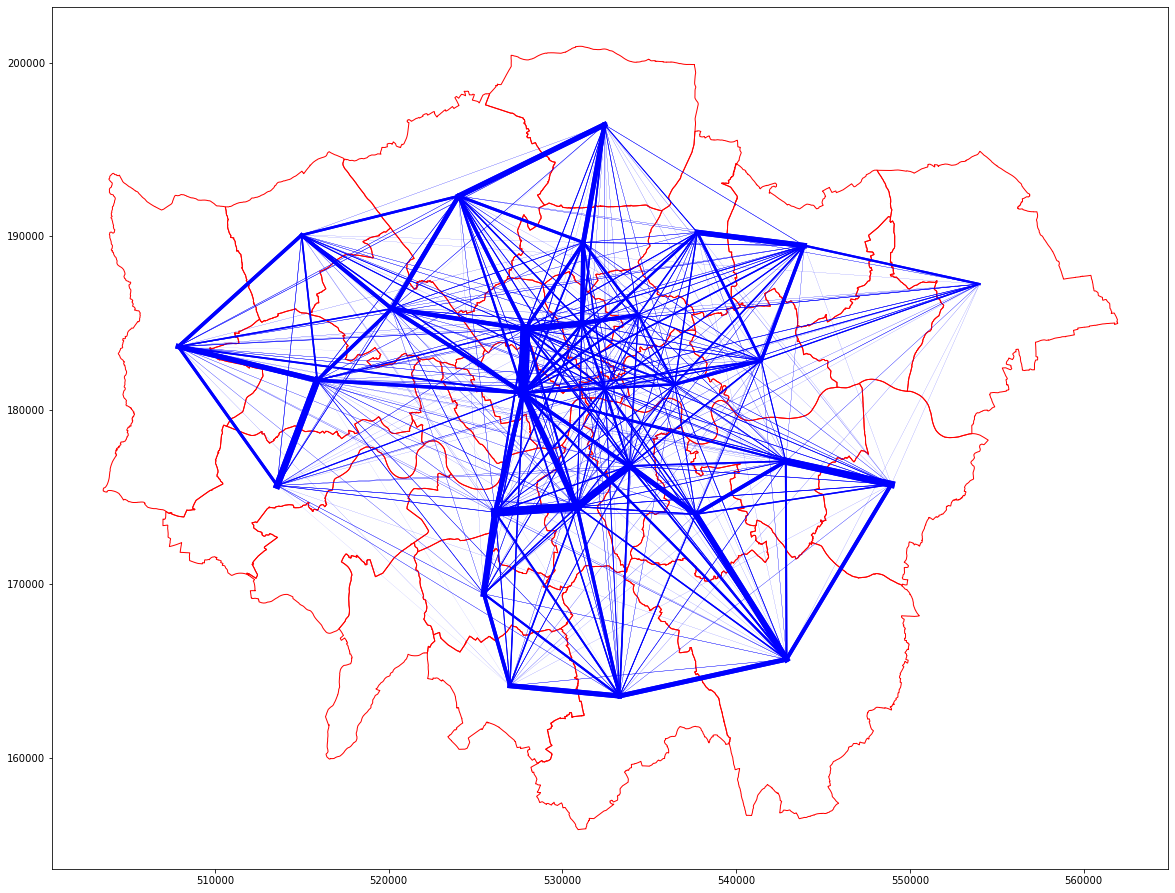

In [51]:
#plot the base map
London.plot(figsize = (20,30), facecolor = "None", edgecolor = "r")

#iterate over each pair
for index, row in cdatasub.iterrows():
    #get the x coordinates
    x1 = [London[London["lad15cd"] == row["OrigCode"]]["Centroids"].x, London[London["lad15cd"] == row["DestCode"]]["Centroids"].x]
    #get the y coordinates
    y1 = [London[London["lad15cd"] == row["OrigCode"]]["Centroids"].y, London[London["lad15cd"] == row["DestCode"]]["Centroids"].y]
    #plot the line between the x and y coordinates with width reflecting the number of flows
    plt.plot(x1, y1, linewidth = row["TotalNoIntra"]/max(cdatasub["TotalNoIntra"])*10, color = "Blue")
    
#be careful when working with large amounts of data

 a leaflet map.

In [52]:
import folium

#set the base map to locate on London
my_map =folium.Map(location = [51.5, 0.1278], zoom_start = 10)

#transform to WGS84
London_WGS = London.to_crs("EPSG:4326")
London_WGS["x"] = London_WGS.geometry.centroid.map(lambda p: p.y)
London_WGS["y"]= London_WGS.geometry.centroid.map(lambda p: p.x)

# style_function = lambda x: {"fillColor": "blue",
#                            "lineColor":"black",
#                            "opacity":0.2}

# folium.GeoJson(London_WGS["geometry"],
#               style_function = style_function).add_to(my_map)

#plot in leaflet
#This is done using the folium library
#iterate over each pair
for index, row in cdatasub.iterrows():
    #get the first set of coordinates
    x1 = [London_WGS[London_WGS["lad15cd"]==row["OrigCode"]]["x"].values[0],
       London_WGS[London_WGS["lad15cd"]==row["OrigCode"]]["y"].values[0]]
    #get the second set of coordinates
    x2 = [ London_WGS[London_WGS["lad15cd"]==row["DestCode"]]["x"].values[0],
           London_WGS[London_WGS["lad15cd"]==row["DestCode"]]["y"].values[0]]
    #create a list of the coordinates
    coords = [x1, x2]
    #add a polyline with size reflective of the number of people
    folium.vector_layers.PolyLine(coords, 
                                  weight = row["TotalNoIntra"]/max(cdatasub["TotalNoIntra"])*20, 
                                  opacity = 0.5
                                 ).add_to(my_map)
                                
#plot the map                                
my_map

/tmp/ipykernel_1493/391692187.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London_WGS["x"] = London_WGS.geometry.centroid.map(lambda p: p.y)
/tmp/ipykernel_1493/391692187.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London_WGS["y"]= London_WGS.geometry.centroid.map(lambda p: p.x)


In [53]:
import numpy as np
#now we can create a pivot table to turn paired list into a matrix, and compute the margin as well
cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat

Dest,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,Greenwich,Hackney,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Lambeth,Lewisham,Merton,Newham,Redbridge,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,All
Orig,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Barnet,NaN,NaN,69.0,1.0,54.0,9.0,1.0,7.0,82.0,NaN,6.0,46.0,41.0,NaN,5.0,4.0,22.0,6.0,1.0,1.0,1.0,2.0,17.0,NaN,8.0,3.0,4.0,36.0,426.0
Bexley,NaN,NaN,NaN,59.0,10.0,9.0,3.0,1.0,2.0,114.0,NaN,4.0,NaN,1.0,1.0,NaN,5.0,10.0,20.0,NaN,1.0,1.0,8.0,1.0,6.0,1.0,2.0,15.0,274.0
Brent,71.0,NaN,NaN,NaN,68.0,3.0,NaN,54.0,7.0,6.0,2.0,9.0,57.0,NaN,23.0,9.0,9.0,3.0,2.0,3.0,3.0,3.0,9.0,NaN,4.0,2.0,7.0,58.0,412.0
Bromley,1.0,61.0,NaN,NaN,11.0,15.0,75.0,1.0,NaN,30.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,21.0,94.0,5.0,3.0,NaN,25.0,5.0,10.0,1.0,4.0,32.0,403.0
Camden,54.0,11.0,69.0,12.0,NaN,28.0,5.0,21.0,13.0,7.0,29.0,45.0,11.0,4.0,6.0,5.0,96.0,28.0,11.0,12.0,11.0,14.0,22.0,3.0,25.0,15.0,23.0,159.0,739.0
City of London,10.0,8.0,5.0,13.0,27.0,NaN,11.0,5.0,3.0,6.0,12.0,20.0,14.0,13.0,5.0,5.0,23.0,15.0,20.0,11.0,16.0,17.0,24.0,3.0,20.0,10.0,29.0,32.0,377.0
Croydon,1.0,3.0,1.0,76.0,7.0,13.0,NaN,5.0,1.0,7.0,3.0,3.0,1.0,1.0,NaN,4.0,5.0,51.0,13.0,31.0,3.0,1.0,24.0,81.0,4.0,NaN,30.0,20.0,389.0
Ealing,8.0,1.0,52.0,1.0,17.0,5.0,6.0,NaN,NaN,2.0,3.0,4.0,26.0,NaN,84.0,105.0,5.0,5.0,3.0,8.0,3.0,5.0,2.0,NaN,5.0,NaN,5.0,54.0,409.0
Enfield,85.0,2.0,4.0,NaN,12.0,4.0,1.0,1.0,NaN,1.0,9.0,73.0,2.0,NaN,6.0,NaN,25.0,2.0,NaN,1.0,1.0,6.0,2.0,NaN,4.0,14.0,NaN,10.0,265.0


Now that we have set everything up its

## Modellin


Below is the classic multiplicate gravity model:

\begin{equation} \tag{1}
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}

This gravity model can be written in the form more familiar from [Wilson's 1971 paper](http://journals.sagepub.com/doi/abs/10.1068/a030001) 

\begin{equation} \tag{2}
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

<b>This model says that the flows between an origin and destination are proportional to the product of the mass of the origin and destination and inversley proportional to the distance between them.
    
As origin and destination masses increase, flows increase, but as distance increases, flows decrease, and vice versa.</b>

- Where $T_{ij}$ is the transition or flow, $T$, between origin $i$ (always the rows in a matrix) and destination $j$ (always the columns in a matrix). If you are not overly familiar with matrix notation, the i and j are just generic indexes to allow us to refer to any cell in the matrix more generally.
- $O$ is a vector (a 1 dimensional matrix - or, if you like, a single line of numbers) of origin attributes which relate to the emissiveness of all origins in the dataset, $i$ - in our sample dataset, we have a vector of origin populations (which I have called Oi1_origpop) and a vector of origin average salaries (which I have called Oi2_origsal) in 2001
- $D$ is a vector of desination of attributes relating to the attractivenss of all destinations in the dataset, $j$ - in our sample dataset, we have a vector of destination populations (which I have called Dj1_destpop) and a vector of destination average salaries (which I have called Dj2_destsal) in 2001
- $d$ is a matrix of costs relating to the flows between $i$ and $j$ - in our case the cost is the distance and it is called ‘dist’ in our dataset.
- $k$, $\alpha$, $\gamma$ and $β$ are all the model parameters to be estimated

$k$ is a constant of proportionality. Given that all flows estimated by the model will sum to any observed flow data used to calibrate the parameters:

\begin{equation} \tag{3}
k = \frac{T}{\sum_i \sum_j O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}}
\end{equation}

and $T$ is the sum of our matrix of observed flows or:

\begin{equation} \tag{4}
T= \sum_i \sum_j T_{ij}
\end{equation}



## Estimating Model Parameters



Text(0, 0.5, 'Total Flows')

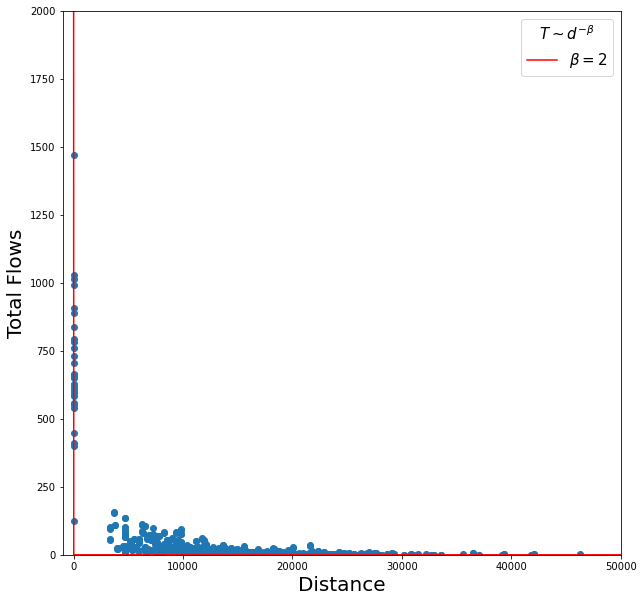

In [83]:
#first plot the Total commuter flows denoted by T against distance denoted by d
#and then fit a model line T ~ d^-beta with beta=2

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["Dist"], y=cdata["total"])
#line plot
line = np.arange(0.0002, 50_000, 0.1)
ax.plot(line, line**-2, color ="r", label = "$\\beta=2$")
#add a legend
ax.legend(title = "$T \\sim d^{-\\beta}$", fontsize = 15, title_fontsize=15)
#axis limits
ax.set_xlim([-1000,50000])
ax.set_ylim([0, 2000])
#set the labels
ax.set_xlabel("Distance", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

What about the origin and destination data

Text(0, 0.5, 'Total Flows')

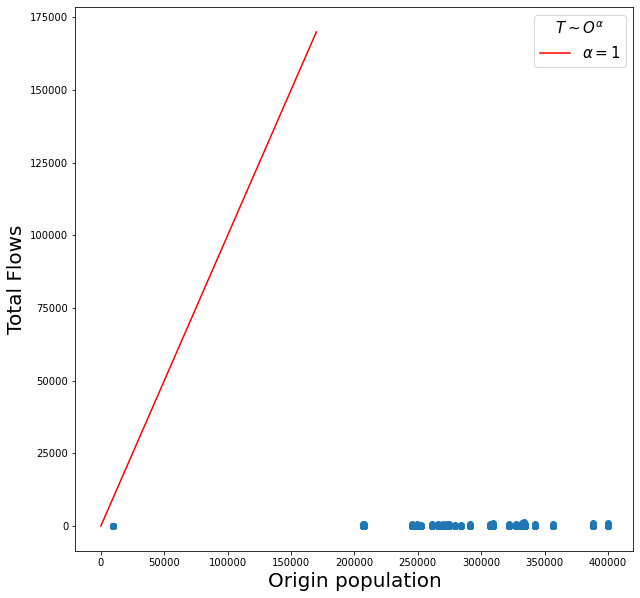

In [55]:
#the flows with respect to the population at the origin denoted by O
#and then fit a model line T ~ O^alpha, for alpha=1

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["Oi1_origpop"], y=cdata["total"])
#line plot
line = np.arange(0.0002, 170_000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\alpha=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim O^{\\alpha}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Origin population", fontsize = 20)
ax.set_ylabel("Total Flows", fontsize = 20)

Text(0, 0.5, 'Total')

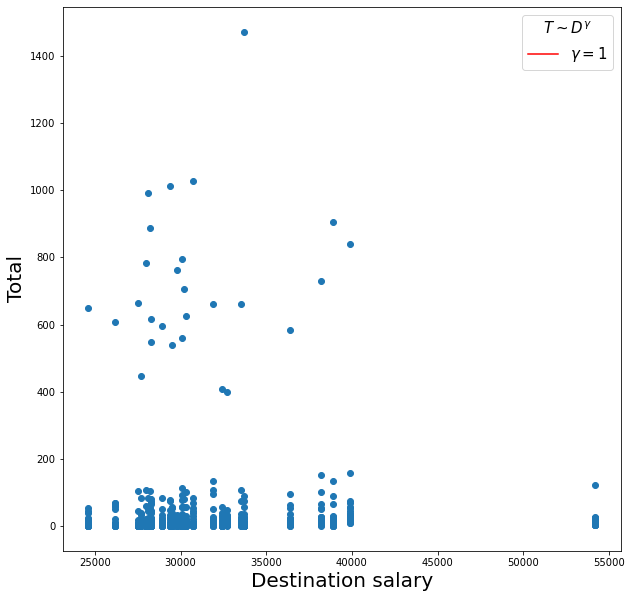

In [56]:
#Now let us look at the behaviour of the flows with respect to the salaries at destination denoted by D
# and then fit a model line  T ~ D^gamma. We will fit a line for gamma=1

#set the base axis
fig, ax = plt.subplots(figsize=(10,10))

#scatter plot
ax.scatter(x = cdata["Dj2_destsal"], y=cdata["total"])
#line plot
line = np.arange(15_000, 3000, 0.1)
ax.plot(line, line**1, color ="r", label = "$\\gamma=1$")
#add a legend
ax.legend( fontsize = 15, title = "$T \sim D^{\\gamma}$", title_fontsize=15)
#axis labels
ax.set_xlabel("Destination salary", fontsize = 20)
ax.set_ylabel("Total", fontsize = 20)

In [57]:
cdatasub.fillna(0)

,OrigCode,DestCode,TotalNoIntra,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,...,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total,OldCode,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,offset,Dist
1,E09000001,E09000003,10.0,City of London,Barnet,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,00AC,9547,54200,400064,30700,0.0,13935.670950
2,E09000001,E09000004,8.0,City of London,Bexley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,00AD,9547,54200,249284,28000,0.0,17359.908682
3,E09000001,E09000005,5.0,City of London,Brent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,00AE,9547,54200,332359,26200,0.0,13119.797208
4,E09000001,E09000006,13.0,City of London,Bromley,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,00AF,9547,54200,333978,33700,0.0,18740.822949
5,E09000001,E09000007,27.0,City of London,Camden,6.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,27.0,00AG,9547,54200,274695,38200,0.0,5742.818336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,E09000033,E09000028,38.0,Westminster,Southwark,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,4.0,0.0,0.0,0.0,38.0,00BE,265990,39900,321758,33500,0.0,7417.933585
673,E09000033,E09000029,20.0,Westminster,Sutton,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,17.0,0.0,0.0,1.0,0.0,0.0,0.0,20.0,00BF,265990,39900,207631,30200,0.0,16878.478719
674,E09000033,E09000030,35.0,Westminster,Tower Hamlets,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,35.0,00BG,265990,39900,331707,32700,0.0,8735.485944
675,E09000033,E09000031,35.0,Westminster,Waltham Forest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,35.0,00BH,265990,39900,278948,27700,0.0,13617.154003


In [58]:
#set up some variables to hold our parameter values in:
alpha = 1
gamma = 1
beta = 2
k = 1
T2 = sum(cdatasub["total"])

In [59]:
#cdatasub.drop(cdatasub[cdatasub["Dist"]==0].index, inplace=True)

Create some flow estimates using equation 2 above

In [60]:
Oi1_alpha = cdatasub["Oi1_origpop"]**alpha
Dj2_gamma = cdatasub["Dj2_destsal"]**gamma
dist_beta = cdatasub["Dist"]**(-beta)
T1 = Oi1_alpha*Dj2_gamma*dist_beta
k = T2/sum(T1)

As in Equation 2 above,  multiply everything together to get your flow estimates.

In [61]:
cdatasub[cdatasub["Dist"]==0]

,OrigCode,DestCode,TotalNoIntra,Orig,Dest,01 Walk (roller blades/ scooters),02 Pedal Cycle,03 Car Driver,04 Car Passenger,05 Motorcycle Rider,06 Motorcycle Passenger,09 Van small Driver,10 Van small Passenger,11 Van/ lorry (other) Driver,12 Van/ lorry (other) Passenger,...,19 National rail train,20 Tramlink,21 Taxi (London black cab),22 Taxi (other/ minicab),23 Plane/ Boat/ Other,24 London Overground,25 TfL Rail,total,OldCode,Oi1_origpop,Oi2_origsal,Dj1_destpop,Dj2_destsal,offset,Dist


In [62]:
dist_beta.describe()

count    6.500000e+02
mean     9.072075e-09
std      1.313576e-08
min      4.673687e-10
25%      2.297136e-09
50%      4.323592e-09
75%      9.370099e-09
max      9.296269e-08
Name: Dist, dtype: float64

In [63]:
#cdatasub["unconstrainedEst1"] = round(k*Oi1_alpha*Dj2_gamma*dist_beta, 0)
#cdatasub["unconstrainedEst1"] 

In [64]:
#run the model and store of the new flow estimates in a new column
cdatasub["unconstrainedEst1"] = round(k*Oi1_alpha*Dj2_gamma*dist_beta, 0)
#convert to integers
cdatasub["unconstrainedEst1"] = cdatasub["unconstrainedEst1"].astype(int)
#check that the sum of these estimates make sense
sum(cdatasub["unconstrainedEst1"])

10976

Turn this into a matrix to look at the predictors flows

In [65]:
cdatasubmat1 = cdatasub.pivot_table(values ="unconstrainedEst1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat1

Dest,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,Greenwich,Hackney,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Lambeth,Lewisham,Merton,Newham,Redbridge,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,All
Orig,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Barnet,NaN,NaN,37.0,3.0,42.0,22.0,3.0,13.0,26.0,NaN,17.0,39.0,27.0,NaN,7.0,6.0,28.0,7.0,5.0,5.0,5.0,6.0,8.0,NaN,10.0,11.0,9.0,22.0,358
Bexley,NaN,NaN,NaN,12.0,4.0,9.0,4.0,1.0,2.0,39.0,NaN,3.0,NaN,9.0,1.0,NaN,5.0,5.0,12.0,NaN,11.0,7.0,7.0,2.0,9.0,4.0,4.0,4.0,154
Brent,36.0,NaN,NaN,NaN,42.0,21.0,NaN,53.0,7.0,3.0,11.0,14.0,44.0,NaN,12.0,12.0,20.0,9.0,4.0,7.0,4.0,3.0,8.0,NaN,8.0,6.0,15.0,33.0,372
Bromley,2.0,14.0,NaN,NaN,4.0,10.0,20.0,2.0,NaN,15.0,5.0,3.0,1.0,3.0,1.0,2.0,5.0,10.0,21.0,6.0,6.0,NaN,11.0,8.0,7.0,3.0,7.0,6.0,172
Camden,23.0,3.0,24.0,3.0,NaN,90.0,3.0,10.0,10.0,6.0,41.0,43.0,8.0,2.0,4.0,5.0,186.0,15.0,8.0,7.0,7.0,6.0,19.0,4.0,21.0,12.0,19.0,163.0,742
City of London,0.0,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,4.0,0.0,1.0,3.0,24
Croydon,3.0,6.0,3.0,27.0,6.0,13.0,NaN,3.0,2.0,9.0,5.0,3.0,2.0,2.0,NaN,4.0,6.0,20.0,18.0,25.0,4.0,3.0,15.0,58.0,8.0,NaN,19.0,9.0,273
Ealing,12.0,2.0,51.0,2.0,17.0,13.0,3.0,NaN,NaN,3.0,6.0,7.0,29.0,NaN,28.0,45.0,10.0,8.0,4.0,9.0,3.0,2.0,7.0,NaN,5.0,NaN,16.0,19.0,301
Enfield,24.0,3.0,7.0,NaN,16.0,16.0,2.0,4.0,NaN,4.0,18.0,40.0,6.0,NaN,2.0,NaN,18.0,4.0,NaN,3.0,6.0,11.0,6.0,NaN,9.0,28.0,NaN,10.0,237


How do the flow estimates compare to the original flows

In [66]:
cdatasubmat

Dest,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,Greenwich,Hackney,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Lambeth,Lewisham,Merton,Newham,Redbridge,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,All
Orig,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Barnet,NaN,NaN,69.0,1.0,54.0,9.0,1.0,7.0,82.0,NaN,6.0,46.0,41.0,NaN,5.0,4.0,22.0,6.0,1.0,1.0,1.0,2.0,17.0,NaN,8.0,3.0,4.0,36.0,426.0
Bexley,NaN,NaN,NaN,59.0,10.0,9.0,3.0,1.0,2.0,114.0,NaN,4.0,NaN,1.0,1.0,NaN,5.0,10.0,20.0,NaN,1.0,1.0,8.0,1.0,6.0,1.0,2.0,15.0,274.0
Brent,71.0,NaN,NaN,NaN,68.0,3.0,NaN,54.0,7.0,6.0,2.0,9.0,57.0,NaN,23.0,9.0,9.0,3.0,2.0,3.0,3.0,3.0,9.0,NaN,4.0,2.0,7.0,58.0,412.0
Bromley,1.0,61.0,NaN,NaN,11.0,15.0,75.0,1.0,NaN,30.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,21.0,94.0,5.0,3.0,NaN,25.0,5.0,10.0,1.0,4.0,32.0,403.0
Camden,54.0,11.0,69.0,12.0,NaN,28.0,5.0,21.0,13.0,7.0,29.0,45.0,11.0,4.0,6.0,5.0,96.0,28.0,11.0,12.0,11.0,14.0,22.0,3.0,25.0,15.0,23.0,159.0,739.0
City of London,10.0,8.0,5.0,13.0,27.0,NaN,11.0,5.0,3.0,6.0,12.0,20.0,14.0,13.0,5.0,5.0,23.0,15.0,20.0,11.0,16.0,17.0,24.0,3.0,20.0,10.0,29.0,32.0,377.0
Croydon,1.0,3.0,1.0,76.0,7.0,13.0,NaN,5.0,1.0,7.0,3.0,3.0,1.0,1.0,NaN,4.0,5.0,51.0,13.0,31.0,3.0,1.0,24.0,81.0,4.0,NaN,30.0,20.0,389.0
Ealing,8.0,1.0,52.0,1.0,17.0,5.0,6.0,NaN,NaN,2.0,3.0,4.0,26.0,NaN,84.0,105.0,5.0,5.0,3.0,8.0,3.0,5.0,2.0,NaN,5.0,NaN,5.0,54.0,409.0
Enfield,85.0,2.0,4.0,NaN,12.0,4.0,1.0,1.0,NaN,1.0,9.0,73.0,2.0,NaN,6.0,NaN,25.0,2.0,NaN,1.0,1.0,6.0,2.0,NaN,4.0,14.0,NaN,10.0,265.0



### Testing the "Goodness-of-fit"


### R-Squared
 


In [67]:
import scipy.stats

def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

CalcRSqaured(cdatasub["total"], cdatasub["unconstrainedEst1"])

0.4020853527177289


### Root Mean Squared Error (RMSE)

use a similar simple function to calcualte the RMSE for our data

In [68]:
from math import sqrt

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

CalcRMSE(cdatasub["total"], cdatasub["unconstrainedEst1"])

22.016

The closer to 0 the RMSE value, the better the model.


## Improving our model: 1 -  calibrating parameters


take the logarithms of both sides of Equation 2, end up with the following equation:

\begin{equation} \tag{5}
\ln T_{ij} = K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij}
\end{equation}

where $K= \ln k$. Those of you who have played around with regression models in the past will realise that this is exactly that - a regression model.


## Poisson regression


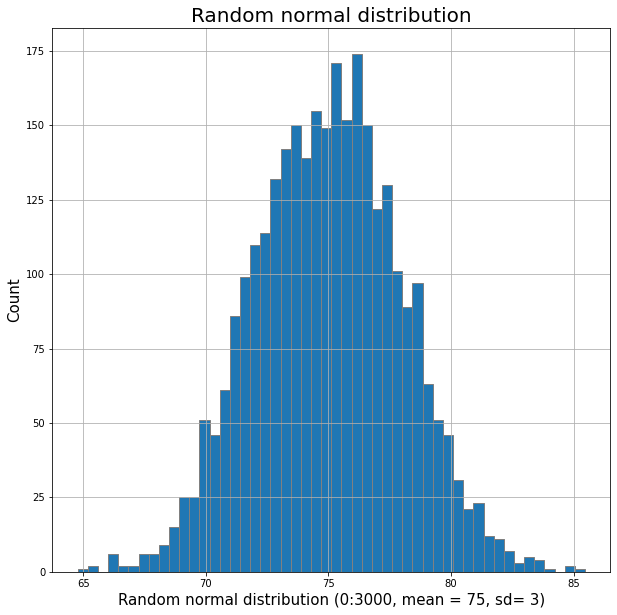

In [69]:
plt.subplots(figsize=(10,10))

plt.hist(np.random.normal(loc = 75, scale= 3, size = 3000 ), bins = 50, edgecolor = "grey")
plt.xlabel("Random normal distribution (0:3000, mean = 75, sd= 3)", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Random normal distribution", fontsize = 20)
plt.grid(True)

Now here’s a Poisson distribution with the same mean:

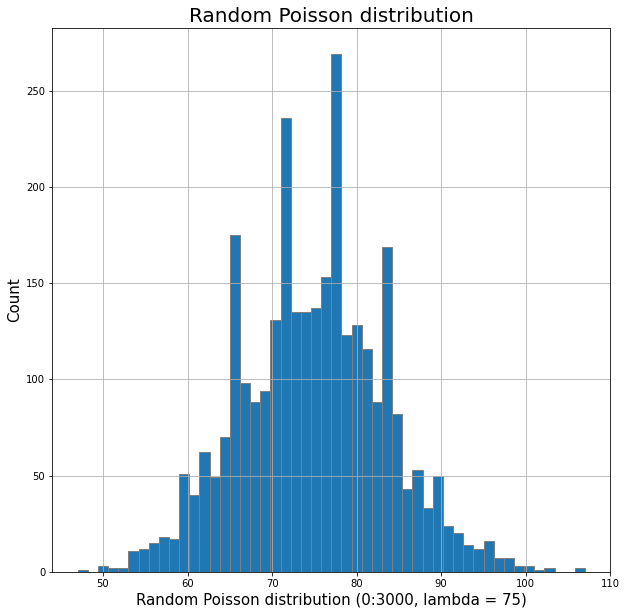

In [70]:
plt.subplots(figsize=(10,10))

plt.hist(np.random.poisson(lam = 75, size = 3000 ), bins = 50, edgecolor = "grey")
plt.xlabel("Random Poisson distribution (0:3000, lambda = 75)", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Random Poisson distribution", fontsize = 20)
plt.grid(True)

Looks kind of similar doesn’t it! The thing with the Poisson distribution is, when the mean (λ - lambda) changes, so does the distribution. As the mean gets smaller (and this is often the case with flow data where small flows are very likely - have a look at the ‘Total’ column in your cdata dataframe, lots of small numbers aren’t there?) the distribution starts to look a lot more like a skewed or log-normal distrbution. The key thing is it’s not - it’s a Poisson distribution. Here’s a similar frequency distribution with a small mean:

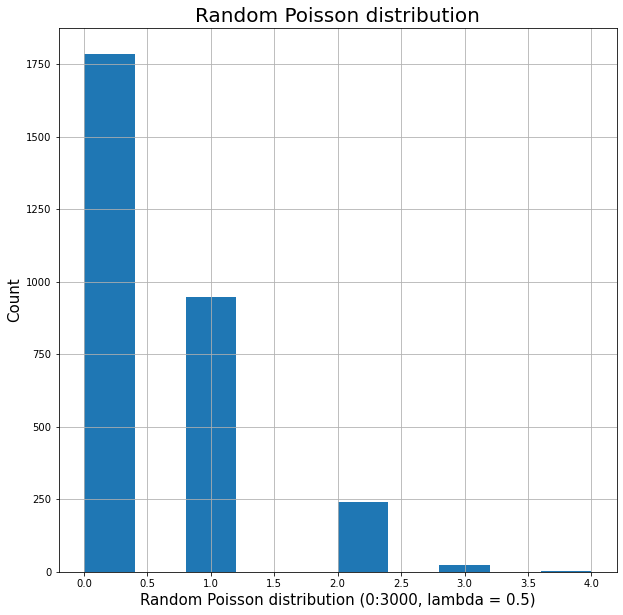

In [71]:
plt.subplots(figsize=(10,10))

plt.hist(np.random.poisson(lam = 0.5, size = 3000))
plt.xlabel("Random Poisson distribution (0:3000, lambda = 0.5)", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("Random Poisson distribution", fontsize = 20)
plt.grid(True)

As far as we’re concerned, what this means is that if we are interested in all flows between all origins and destinations in our system, these flows will have a mean value of $\lambda_{ij}$ and this will dictate the distribution. Here’s what the distrbution of our flows looks like:

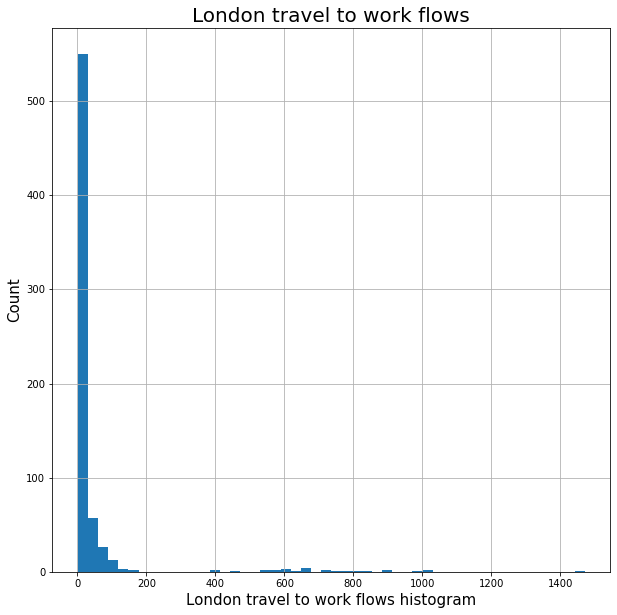

In [72]:
plt.subplots(figsize=(10,10))

plt.hist(cdata["total"], histtype="stepfilled" , bins = 50)
plt.xlabel("London travel to work flows histogram", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("London travel to work flows", fontsize = 20)
plt.grid(True)

### Poisson

By logging both sides of the equation in Equation 5, get a situation where our Tij flows can be modelled by using the values of our other variables such as distance, by using a straight line a bit like this:

Text(0, 0.5, 'log(total)')

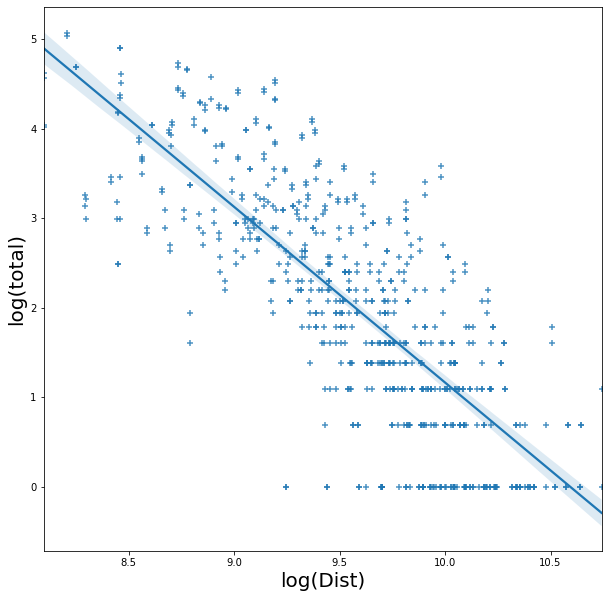

In [73]:
#subset the dataframe to the flows we want
cdata_flows = cdata[["total", "Dist"]]
#remove all 0 values (logarithms can't deal with 0 values)
cdata_flows = cdata_flows[(cdata_flows!=0).all(1)]

#extract the x and y converting to log
x = np.log(cdata_flows["Dist"])
y = np.log(cdata_flows["total"])

#create the subplot
fig, ax = plt.subplots(figsize = (10,10))
#plot the results along with the line of best fit
sns.regplot(x=x, y=y, marker="+", ax=ax)
ax.set_xlabel("log(Dist)", fontsize = 20)
ax.set_ylabel("log(total)", fontsize = 20)

### The Poisson Regression Spatial Interaction Model

re-specify Equation 5 as a Poisson Regression model. Basically, assuming that the flows follow a Poisson distribution, such that the expected value $\lambda_{ij}$ verifies:

\begin{equation} \tag{6}
\lambda_{ij} = \exp (K + \alpha \ln O_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

This model says that $\lambda_{ij}$ (our independent variable - the estimate of $T_{ij}$) is <i>logarithmically linked </i> to (or modelled by) a linear combination of the logged independent variables in the model. 

Now use a Poisson regression model to produce estimated of $k$, $\alpha$, $\gamma$ and $\beta$ - or put another way, use the rgeression model to calibrate our parameters.


In [74]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#take the variables and produce logarithms of them
x_variables = ["Oi1_origpop", "Dj2_destsal", "Dist"]
log_x_vars = []
for x in x_variables:
    cdatasub[f"log_{x}"] = np.log(cdatasub[x])
    log_x_vars.append(f"log_{x}")

#create the formula
formula = 'total ~ log_Oi1_origpop + log_Dj2_destsal + log_Dist'

#run the regression
uncosim = smf.glm(formula = formula, 
                  data=cdatasub, 
                  family=sm.families.Poisson()).fit()


It’s a simple as that - runs in a matter of milliseconds. You should be able to see how the `glm` code corresponds to Equation 6.

`Total` = $T_{ij}$ = $\lambda_{ij}$

`~` means ‘is modelled by’

`log_Oi1_origpop` = $\ln O_i$

`log_Dj2_destsal` = $\ln D_j$

`log_dist` = $\ln d_{ij}$

`family=sm.families.Poisson()`means that we are using a Poisson regression model (the link is always log with a Poisson model) where the left-hand side of the model equation is logarithmically linked to the variables on the right-hand side.

So what comes out of the other end?

Well, we can use the `summary()` function to have a look at the model parameters:

In [75]:
#extract the summary of the constrained model
print(uncosim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  total   No. Observations:                  650
Model:                            GLM   Df Residuals:                      646
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4085.2
Date:                Mon, 19 Sep 2022   Deviance:                       5633.3
Time:                        04:45:12   Pearson chi2:                 6.53e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          20.3808      0.666     

In [76]:
#first assign the parameter values from the model to the appropriate variables
K = uncosim.params[0]
alpha = uncosim.params[1]
gamma = uncosim.params[2]
beta = -uncosim.params[3]

#now plug everything back into the Equation 6 model ... 
cdatasub["unconstrainedEst2"] = np.exp(K 
                                       + alpha*cdatasub["log_Oi1_origpop"] 
                                       + gamma*cdatasub["log_Dj2_destsal"] 
                                       - beta*cdatasub["log_Dist"])

#extract the results from the actual poisson regression and apply them to the data
predictions = uncosim.get_prediction()
predictions_summary_frame = predictions.summary_frame()
cdatasub["fitted"] = predictions_summary_frame["mean"]

In [77]:
uncosim.mu

array([  5.65933333,   4.05873162,   6.71623942,   3.28876491,
        23.12986923,   3.84425438,   4.37320912,   5.06198834,
         8.2714053 ,  35.27660536,  13.51833835,   3.23367957,
         2.56998711,   2.22995641,   3.30642626,  43.86248526,
        17.99265502,  12.20335175,   5.84837433,  12.77114839,
         5.68973328,  35.03990472,   3.71147164,  45.43554598,
         9.65290632,   9.73937865,  31.61990723,  10.0837327 ,
        39.1612424 ,   2.92591704,  26.82224986,   3.54025146,
        14.38126637,  26.33416624,  15.38212282,  36.93800783,
        26.00052291,   8.44217643,   7.55698928,  20.31592062,
         7.42094897,   5.6377521 ,   5.57820261,   7.82549463,
         7.12976409,   7.77721304,   9.43436687,  13.57942488,
         7.32407291,  15.02157626,   6.25879623,  14.95046288,
         4.5625349 ,   6.52321238,   2.71757109,   4.06018734,
        46.0926393 ,   5.33294041,  13.98062106,   1.87783851,
         5.82316014,   7.3214957 ,  16.51552361,  21.24

In [78]:
#round the numbers so that we don't get a half of a person
cdatasub["unconstrainedEst2"] = round(cdatasub["unconstrainedEst2"], 0)
#convert to integers
cdatasub["unconstrainedEst2"] = cdatasub["unconstrainedEst2"].astype(int)
#check that the sum of these estimates make sense
sum(cdatasub["unconstrainedEst2"])

10986

In [79]:
#turn it into a little matrix
cdatasubmat2 = cdatasub.pivot_table(values ="unconstrainedEst2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

Dest,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,Greenwich,Hackney,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Lambeth,Lewisham,Merton,Newham,Redbridge,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,All
Orig,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Barnet,NaN,NaN,39.0,3.0,27.0,10.0,4.0,14.0,26.0,NaN,15.0,37.0,26.0,NaN,8.0,8.0,20.0,7.0,6.0,6.0,8.0,7.0,8.0,NaN,9.0,14.0,7.0,15.0,324
Bexley,NaN,NaN,NaN,15.0,5.0,6.0,7.0,3.0,4.0,46.0,NaN,5.0,NaN,14.0,2.0,NaN,6.0,7.0,17.0,NaN,21.0,11.0,10.0,4.0,12.0,8.0,5.0,5.0,213
Brent,35.0,NaN,NaN,NaN,30.0,11.0,NaN,55.0,10.0,5.0,12.0,17.0,44.0,NaN,16.0,16.0,17.0,10.0,6.0,9.0,7.0,5.0,9.0,NaN,9.0,8.0,12.0,23.0,366
Bromley,3.0,17.0,NaN,NaN,4.0,6.0,23.0,3.0,NaN,18.0,6.0,4.0,2.0,5.0,2.0,3.0,5.0,11.0,23.0,8.0,10.0,NaN,11.0,10.0,9.0,5.0,7.0,5.0,200
Camden,27.0,5.0,34.0,4.0,NaN,42.0,6.0,15.0,15.0,9.0,42.0,51.0,12.0,4.0,7.0,9.0,128.0,18.0,11.0,10.0,13.0,9.0,20.0,6.0,23.0,18.0,17.0,102.0,657
City of London,6.0,4.0,7.0,3.0,23.0,NaN,4.0,4.0,5.0,8.0,35.0,14.0,3.0,3.0,2.0,3.0,44.0,18.0,12.0,6.0,13.0,6.0,35.0,4.0,45.0,10.0,10.0,32.0,359
Croydon,3.0,7.0,5.0,22.0,5.0,7.0,NaN,5.0,3.0,10.0,6.0,5.0,3.0,3.0,NaN,6.0,6.0,18.0,18.0,24.0,7.0,4.0,13.0,49.0,8.0,NaN,13.0,7.0,257
Ealing,13.0,3.0,57.0,3.0,14.0,7.0,5.0,NaN,NaN,4.0,7.0,9.0,30.0,NaN,32.0,48.0,10.0,9.0,5.0,10.0,5.0,4.0,7.0,NaN,6.0,NaN,13.0,15.0,316
Enfield,24.0,4.0,10.0,NaN,13.0,8.0,3.0,6.0,NaN,6.0,18.0,42.0,8.0,NaN,4.0,NaN,16.0,6.0,NaN,4.0,10.0,14.0,7.0,NaN,10.0,32.0,NaN,9.0,254


In [80]:
#compare it to the actual flows
cdatasubmat

Dest,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,Greenwich,Hackney,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Lambeth,Lewisham,Merton,Newham,Redbridge,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,All
Orig,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Barnet,NaN,NaN,69.0,1.0,54.0,9.0,1.0,7.0,82.0,NaN,6.0,46.0,41.0,NaN,5.0,4.0,22.0,6.0,1.0,1.0,1.0,2.0,17.0,NaN,8.0,3.0,4.0,36.0,426.0
Bexley,NaN,NaN,NaN,59.0,10.0,9.0,3.0,1.0,2.0,114.0,NaN,4.0,NaN,1.0,1.0,NaN,5.0,10.0,20.0,NaN,1.0,1.0,8.0,1.0,6.0,1.0,2.0,15.0,274.0
Brent,71.0,NaN,NaN,NaN,68.0,3.0,NaN,54.0,7.0,6.0,2.0,9.0,57.0,NaN,23.0,9.0,9.0,3.0,2.0,3.0,3.0,3.0,9.0,NaN,4.0,2.0,7.0,58.0,412.0
Bromley,1.0,61.0,NaN,NaN,11.0,15.0,75.0,1.0,NaN,30.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,21.0,94.0,5.0,3.0,NaN,25.0,5.0,10.0,1.0,4.0,32.0,403.0
Camden,54.0,11.0,69.0,12.0,NaN,28.0,5.0,21.0,13.0,7.0,29.0,45.0,11.0,4.0,6.0,5.0,96.0,28.0,11.0,12.0,11.0,14.0,22.0,3.0,25.0,15.0,23.0,159.0,739.0
City of London,10.0,8.0,5.0,13.0,27.0,NaN,11.0,5.0,3.0,6.0,12.0,20.0,14.0,13.0,5.0,5.0,23.0,15.0,20.0,11.0,16.0,17.0,24.0,3.0,20.0,10.0,29.0,32.0,377.0
Croydon,1.0,3.0,1.0,76.0,7.0,13.0,NaN,5.0,1.0,7.0,3.0,3.0,1.0,1.0,NaN,4.0,5.0,51.0,13.0,31.0,3.0,1.0,24.0,81.0,4.0,NaN,30.0,20.0,389.0
Ealing,8.0,1.0,52.0,1.0,17.0,5.0,6.0,NaN,NaN,2.0,3.0,4.0,26.0,NaN,84.0,105.0,5.0,5.0,3.0,8.0,3.0,5.0,2.0,NaN,5.0,NaN,5.0,54.0,409.0
Enfield,85.0,2.0,4.0,NaN,12.0,4.0,1.0,1.0,NaN,1.0,9.0,73.0,2.0,NaN,6.0,NaN,25.0,2.0,NaN,1.0,1.0,6.0,2.0,NaN,4.0,14.0,NaN,10.0,265.0


In [81]:
CalcRSqaured(cdatasub["total"], cdatasub["unconstrainedEst2"])

0.5351302336392093

In [82]:
CalcRMSE(cdatasub["total"], cdatasub["unconstrainedEst2"])

16.284